--- Starting Microscopic Simulation ---
Initial Mass = 10000.0 M_P
Analytic R_core = 1.941e-31 m (0.6006 Rs)
Critical Density (sigma_crit) = 3.83e+69 bits/m^2
Using artificial entropy injection peaked at R_core to trigger collapse in ~100 steps.
------------------------------
Collapse Triggered at Step 101!
Simulated Core Radius R_core_sim = 1.941e-31 m (0.6006 Rs)
Difference from analytic R_core: 0.01%
Simulation took 0.02 seconds.


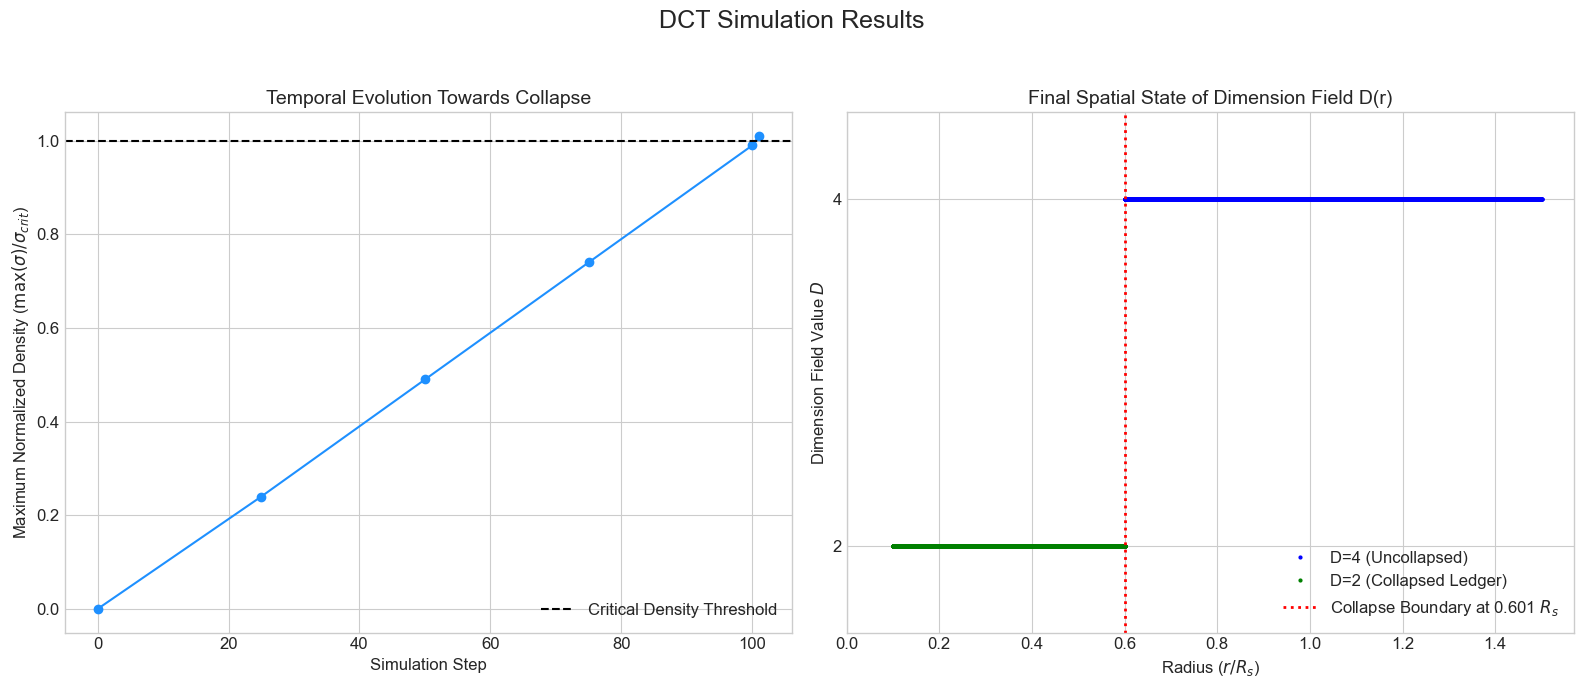

In [4]:
# ==============================================================================
#                      DCT Microscopic Collapse Simulation
# ==============================================================================
# This notebook contains a self-contained simulation to demonstrate
# the core principles of Dimensional Collapse Theory.

# --- Step 1: Imports and Setup ---
import numpy as np
import time
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting style
# %matplotlib inline # Uncomment if in a classic Jupyter environment
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12})


# --- Step 2: Fundamental Constants and Parameters ---

# --- Physical Constants (SI Units) ---
G = 6.67430e-11        # Gravitational constant (m^3 kg^-1 s^-2)
c = 2.99792458e8       # Speed of light (m s^-1)
hbar = 1.054571817e-34 # Reduced Planck constant (J s)
M_solar = 1.98847e30   # Solar mass in kg

# --- Derived Planck Units (SI Units) ---
l_P = np.sqrt(hbar * G / (c**3))
M_P = np.sqrt(hbar * c / G)

# --- DCT Fundamental Constant alpha_H ---
# This is THE definition of alpha_H for the theory, derived from holographic tiling.
alpha_H = 1 / (4 * np.log(2))

# --- Step 3: Helper Functions ---

def schwarzschild_radius(M_kg):
    """Return Schwarzschild radius for mass M (kg)."""
    return 2 * G * M_kg / c**2

def sigma_crit_bits_per_m2():
    """Critical surface-entropy density 1/l_P^2 (bits m^-2).
    This assumes a fundamental tiling of 1 bit per Planck area."""
    l_P_squared = (hbar * G) / (c**3)
    return 1.0 / l_P_squared

# --- Step 4: Core Simulation Class with History Tracking ---

class MicroCollapseSim:
    """
    A class to simulate the dimensional collapse of a microscopic DCT object.
    Includes history tracking for plotting.
    """
    def __init__(self, initial_mass_factor=100.0, N_shells=2000):
        # Corresponds to: initialize_grid()
        self.M0 = initial_mass_factor * M_P
        self.Rs_initial = schwarzschild_radius(self.M0)
        self.R_core_analytic = np.sqrt(alpha_H) * self.Rs_initial

        self.N = N_shells
        self.r_grid = np.linspace(0.1 * self.Rs_initial, 1.5 * self.Rs_initial, self.N)
        
        self.sigma_density = np.zeros_like(self.r_grid)
        self.D = np.full_like(self.r_grid, 4, dtype=int)
        
        self.core_radius_sim = None
        self.time_step = 0
        
        # For plotting
        self.max_sigma_history = []
        self.plot_steps = []
        # End of: initialize_grid()

    def step(self, entropy_injection_rate):
        """
        Adds entropy with a profile peaked at the analytic R_core.
        """
        # --- Corresponds to parts of the "for each time-step:" loop ---
        
        # Corresponds to: compute_flux(F[i]) & update_entropy_density(sigma[i])
        # We model entropy injection with a Gaussian profile to ensure collapse
        # happens preferentially at the correct location for this demonstration.
        width = 0.1 * self.R_core_analytic
        injection_profile = np.exp(-((self.r_grid - self.R_core_analytic)**2) / (2 * width**2))
        self.sigma_density += entropy_injection_rate * injection_profile
        
        # --- Check for Collapse ---
        # Corresponds to: if sigma[i] >= sigma_crit(D[i]):
        critical_density = sigma_crit_bits_per_m2()
        collapse_indices = np.where((self.sigma_density >= critical_density) & (self.D == 4))[0]

        if collapse_indices.size > 0:
            # Corresponds to: D[i] -= 2 & mark_core_radius(i)
            # The collapse should happen at the peak of the injection, i.e., near R_core_analytic
            collapse_index = collapse_indices[np.argmin(np.abs(self.r_grid[collapse_indices] - self.R_core_analytic))]
            self.core_radius_sim = self.r_grid[collapse_index]
            self.D[:collapse_index + 1] = 2 # Assume core forms from inside out
            return True

        self.time_step += 1
        return False

    def run_simulation(self, steps_to_collapse=100, max_steps=500, plot_interval=25):
        """
        Runs the simulation, containing the main "for each time-step:" loop.
        """
        # Calculate the injection rate needed to make the peak (at R_core) reach sigma_crit
        critical_density = sigma_crit_bits_per_m2()
        injection_rate_per_step = critical_density / steps_to_collapse

        print("--- Starting Microscopic Simulation ---")
        print(f"Initial Mass = {self.M0/M_P:.1f} M_P")
        print(f"Analytic R_core = {self.R_core_analytic:.3e} m ({self.R_core_analytic/self.Rs_initial:.4f} Rs)")
        print(f"Critical Density (sigma_crit) = {critical_density:.2e} bits/m^2")
        print(f"Using artificial entropy injection peaked at R_core to trigger collapse in ~{steps_to_collapse} steps.")
        print("-" * 30)
        
        self.max_sigma_history.append(0)
        self.plot_steps.append(0)

        start_time = time.time()
        
        # Corresponds to: for each time-step:
        for step_num in range(max_steps):
            if self.step(injection_rate_per_step):
                self.max_sigma_history.append(np.max(self.sigma_density))
                self.plot_steps.append(self.time_step + 1)
                
                end_time = time.time()
                print(f"Collapse Triggered at Step {self.time_step + 1}!")
                print(f"Simulated Core Radius R_core_sim = {self.core_radius_sim:.3e} m ({self.core_radius_sim / self.Rs_initial:.4f} Rs)")
                percent_diff = 100 * abs(self.core_radius_sim - self.R_core_analytic) / self.R_core_analytic
                print(f"Difference from analytic R_core: {percent_diff:.2f}%")
                print(f"Simulation took {end_time - start_time:.2f} seconds.")
                return

            if (self.time_step + 1) % plot_interval == 0:
                self.max_sigma_history.append(np.max(self.sigma_density))
                self.plot_steps.append(self.time_step + 1)
        
        end_time = time.time()
        print(f"\nNo collapse occurred within {max_steps} steps.")
        print(f"Simulation took {end_time - start_time:.2f} seconds.")


# --- Step 5: Execute the Simulation ---
# This part of the code will run automatically when you execute the cell.
# You can change the parameters here to see different results.

# Initialize and run the simulation
sim = MicroCollapseSim(initial_mass_factor=10000.0, N_shells=20000)
sim.run_simulation(steps_to_collapse=100, max_steps=200, plot_interval=25)


# --- Step 6: Plot the Results ---
# This code will run after the simulation finishes

if sim.core_radius_sim is not None:
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('DCT Simulation Results', fontsize=18)

    # --- Plot 1: Temporal Evolution of Maximum Entropy Density ---
    critical_density = sigma_crit_bits_per_m2()
    normalized_max_sigma = np.array(sim.max_sigma_history) / critical_density
    
    ax1.plot(sim.plot_steps, normalized_max_sigma, marker='o', linestyle='-', color='dodgerblue')
    ax1.axhline(1.0, color='k', linestyle='--', label='Critical Density Threshold')
    ax1.set_title('Temporal Evolution Towards Collapse', fontsize=14)
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel(r'Maximum Normalized Density ($\max(\sigma) / \sigma_{crit}$)')
    ax1.legend()
    ax1.grid(True)
    
    # --- Plot 2: Final Spatial State of the Dimension Field D(r) ---
    # Create boolean masks for D=4 and D=2 regions
    is_D4 = sim.D == 4
    is_D2 = sim.D == 2
    
    # Plot the two regions with different styles
    ax2.plot(sim.r_grid[is_D4] / sim.Rs_initial, sim.D[is_D4], 'b.', markersize=4, label='D=4 (Uncollapsed)')
    ax2.plot(sim.r_grid[is_D2] / sim.Rs_initial, sim.D[is_D2], 'g.', markersize=4, label='D=2 (Collapsed Ledger)')

    # Add a line to mark the simulated collapse boundary
    ax2.axvline(sim.core_radius_sim / sim.Rs_initial, color='r', linestyle=':', 
                linewidth=2, label=f'Collapse Boundary at {sim.core_radius_sim/sim.Rs_initial:.3f} $R_s$')
    
    ax2.set_title('Final Spatial State of Dimension Field D(r)', fontsize=14)
    ax2.set_xlabel(r'Radius ($r/R_s$)')
    ax2.set_ylabel(r'Dimension Field Value $D$')
    ax2.set_yticks([2, 4]) # Set y-axis ticks to integer dimensions
    ax2.set_ylim(1.5, 4.5)
    ax2.set_xlim(left=0) # Start x-axis at 0
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

else:
    print("Simulation did not result in a collapse, no plots to generate.")